In [111]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, get_hash, page_map, quest_map, attention, did_map, pass_stmap
import matplotlib.pyplot as plt, pandas as pd, numpy as np, seaborn as sns
from scipy.stats import shapiro, yeojohnson, kruskal
from selenium import webdriver
from selenium.webdriver.common.by import By
from collections import defaultdict
import scikit_posthocs as sp
import json, os

dpath = 'data/password/'
pfile = os.path.join(dpath, 'pstrength.json')

In [112]:
password_response, time_response, survey_response, dids = get_responses()

Total: 163; 
Attentive: 131; Non Attentive: 32


In [113]:
password_response_df = pd.DataFrame(password_response)
passwords = password_response_df['password2'].to_list()

pass_strength = {}
if os.path.exists(pfile):
    with open(pfile, "r") as fp:
        pass_strength.update(json.load(fp))
else:
    driver = webdriver.Chrome()
    driver.get("https://passwordmonster.com")

    for pss in passwords:
        element = driver.find_element(By.ID, 'lgd_out_pg_pass')
        element.send_keys(pss)
        element.clear()
        complexity = driver.find_element(By.ID, 'complexity-span')
        pass_strength[pss] = complexity.get_attribute("innerHTML")

    with open(pfile, "w") as fp:
        json.dump(pass_strength, fp)

In [114]:
password_response_df['Actual Strength'] = password_response_df['password2'].apply(lambda x: pass_stmap.get(pass_strength.get(x)))
password_response_df['Password Hash'] = password_response_df['password2'].apply(lambda x: get_hash(x))
password_response_df.head()

,password2,password2_recall1,password2_recall2,password2_recall3,Actual Strength,Password Hash
0,Prolific1!,NaN,NaN,NaN,-3.0,a14f32b462e83689e9820c50e36231d1
1,pSVNLb85CUNPCwX,NaN,NaN,NaN,3.0,5e956eaff03bbcd8acc77fc51b33f33c
2,CozyBi11$,NaN,NaN,NaN,-1.5,587296705f54585df23d8ea09d0705e5
3,PRO333TECT,NaN,NaN,NaN,3.0,e4ebec85b9b9ce9f0db56130866dd4b7
4,amandanike@91s,NaN,NaN,NaN,0.0,803fd45b05d4a5a35096a9f8794db00d


In [115]:
survey_response_df = pd.DataFrame(survey_response)

page_id = '3'
normqsid = ['1-1', '1-4']
fpass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
normfpass = 8 - fpass.loc[normqsid]
fpass.update(normfpass)

new_index = {}
for qsid in fpass.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('title')
fpass.rename(columns=new_index, inplace=True)
fpass = fpass.rename(new_index)
password_generation = pd.DataFrame(fpass.T.mean(axis=1), columns=['Password Generation'])
pg_prenorm = password_generation.join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))

# normalize scale 1 to 8 to scale -3 to 3
normspassb = password_generation - 4
password_generation.update(normspassb)

/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_56754/366780574.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fpass.update(normfpass)


In [116]:
page_id = '12'
normqsid = []
spass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
spass.drop(attention.get('12'), inplace=True)
normspass = 8 - spass.loc[normqsid]
spass.update(normspass)

# normalize scale 1 to 8 to scale -3 to 3
# normspass = spass - 4
# spass.update(normspass)

new_index = {}
for qsid in spass.index:
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('keyword')
new_index
spass = spass.rename(new_index)
spass = spass.T

In [117]:
password = spass.join(password_generation).join(password_response_df['Actual Strength']).join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))
password.to_csv("data/csvs/password.csv", index=False)
display(password.head())
password.mean()

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Password Generation,Actual Strength,design
0,6,5,1,2,1,3,-1.25,-3.0,Metaphor
1,7,1,7,1,1,4,1.75,3.0,Personal
2,6,6,2,3,1,6,-2.00,-1.5,Consequences
3,6,7,6,1,1,6,1.50,3.0,Consequences
4,7,7,6,1,1,7,1.75,0.0,Logos


/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_56754/2300871009.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  password.mean()


Password Strength          5.877863
Motivation After Design    5.755725
Hard to Remember           4.305344
Guessed by Hacker          2.961832
Guessed by FnF             2.702290
Stronger than Usual        4.763359
Password Generation        0.583969
Actual Strength           -0.137405
dtype: float64

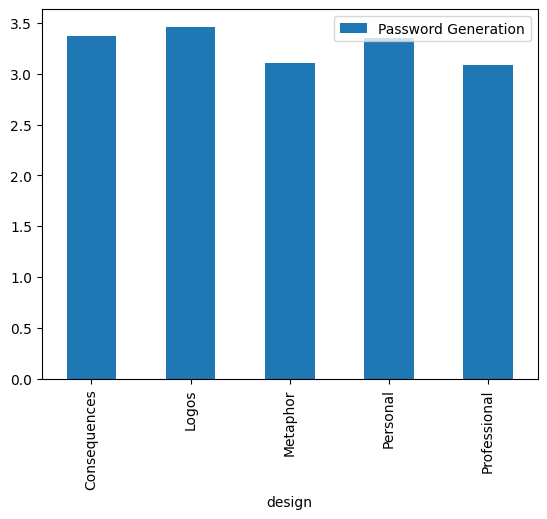

In [118]:
_ = pg_prenorm.groupby('design').mean().div(7).mul(5).plot.bar()

In [119]:
password.head()

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Password Generation,Actual Strength,design
0,6,5,1,2,1,3,-1.25,-3.0,Metaphor
1,7,1,7,1,1,4,1.75,3.0,Personal
2,6,6,2,3,1,6,-2.00,-1.5,Consequences
3,6,7,6,1,1,6,1.50,3.0,Consequences
4,7,7,6,1,1,7,1.75,0.0,Logos


In [120]:
len(password_response_df['password2_recall1'].dropna()), len(password_response_df['password2_recall2'].dropna()), len(password_response_df['password2_recall3'].dropna())

(4, 2, 1)

  Actual Strength  Count
0       Very Weak     36
1     Very Strong     31
2          Medium     24
3            Weak     21
4          Strong     19


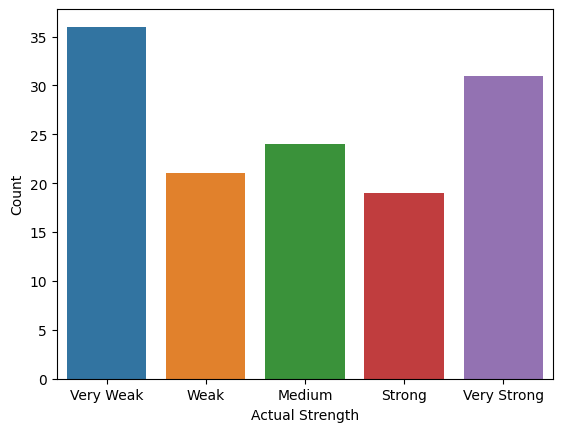

In [121]:
strength_count = password['Actual Strength'].apply(lambda x: list(pass_stmap.keys())[list(pass_stmap.values()).index(x)]).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
_ = sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'])

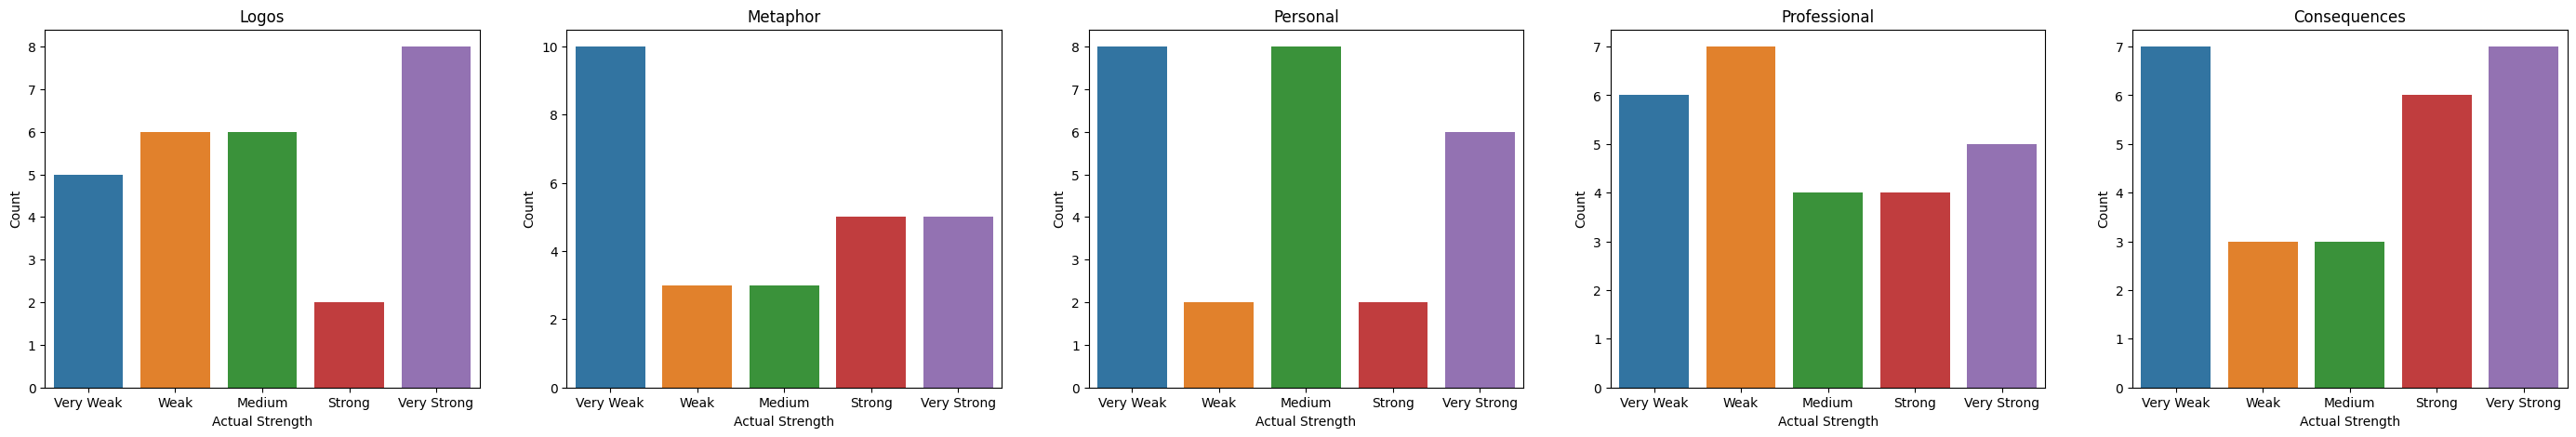

In [122]:
fig, axes = plt.subplots(1, 5,  figsize=(35, 5))
temp = password[['Actual Strength', 'design']]

def get_strength(x):
    return list(pass_stmap.keys())[list(pass_stmap.values()).index(float(x))]


for i, design in enumerate(did_map.values()):
    df = temp[temp['design']==design]['Actual Strength']
    strength_count = df.apply(lambda x: get_strength(x)).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
    sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'], ax= axes[i])
    axes[i].set_title(design)

In [123]:
temp.groupby('design')['Actual Strength'].mean()

design
Consequences    0.173077
Logos           0.111111
Metaphor       -0.461538
Personal       -0.230769
Professional   -0.288462
Name: Actual Strength, dtype: float64

In [124]:
test = {}
designs = []
quests = temp.columns.to_list()
quests.remove('design')
for i, param in enumerate(quests):
    test[param] = []
    for design in did_map.values():
        test[param].append(temp[temp['design']==design][param].to_list())
        designs.append(design) if i<=0 else None
# test

In [125]:
# Performing kruskal test
for k, v in test.items():
    print(f'{k}: {kruskal(*v)}')

Actual Strength: KruskalResult(statistic=1.5231993795167234, pvalue=0.8225241962142404)


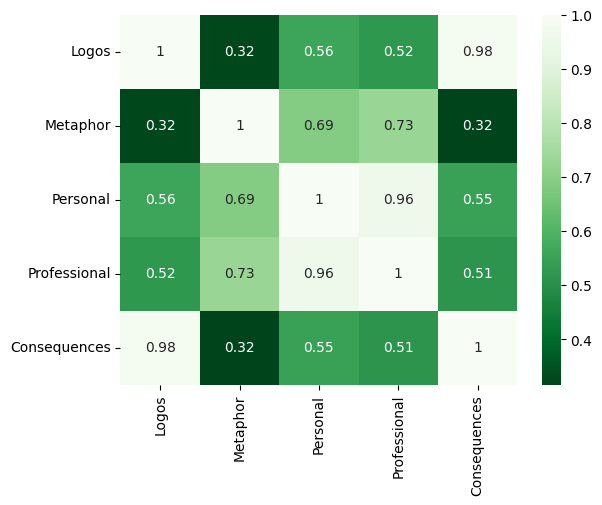

In [126]:
data = sp.posthoc_dunn(test[quests[0]])
data.index = data.index.map(get_design)
data.columns = data.columns.map(get_design)
_ = sns.heatmap(data, annot=True, cmap="Greens_r")